In [1]:
from fastai.vision.all import *

### NIH Chest14 Dataset

In [2]:
datapath = Path("../../data/nih-cxr/")

In [3]:
print(sorted(datapath.ls().map(lambda o: o.name)))

['ARXIV_V5_CHESTXRAY.pdf', 'BBox_List_2017.csv', 'Data_Entry_2017.csv', 'FAQ_CHESTXRAY.pdf', 'LOG_CHESTXRAY.pdf', 'README_CHESTXRAY.pdf', 'images_001', 'images_002', 'images_003', 'images_004', 'images_005', 'images_006', 'images_007', 'images_008', 'images_009', 'images_010', 'images_011', 'images_012', 'test_list.txt', 'train_val_list.txt']


In [4]:
train_val_fns = L(np.loadtxt(datapath/'train_val_list.txt', dtype=str).tolist())
test_fns = L(np.loadtxt(datapath/'test_list.txt', dtype=str).tolist())

In [5]:
train_val_fns, test_fns

((#86524) ['00000001_000.png','00000001_001.png','00000001_002.png','00000002_000.png','00000004_000.png','00000005_000.png','00000005_001.png','00000005_002.png','00000005_003.png','00000005_004.png'...],
 (#25596) ['00000003_000.png','00000003_001.png','00000003_002.png','00000003_003.png','00000003_004.png','00000003_005.png','00000003_006.png','00000003_007.png','00000013_000.png','00000013_001.png'...])

In [6]:
all_image_files = []
for o in datapath.ls().filter(lambda o: o.name.startswith("images")): all_image_files.extend(get_image_files(o))

In [7]:
len(all_image_files)

112120

In [8]:
train_val_fns, test_fns = set(train_val_fns), set(test_fns)

In [9]:
train_val_files = L(all_image_files).filter(lambda o: o.name in train_val_fns)
test_val_files = L(all_image_files).filter(lambda o: o.name in test_fns)

In [10]:
len(train_val_files), len(test_val_files)

(86524, 25596)

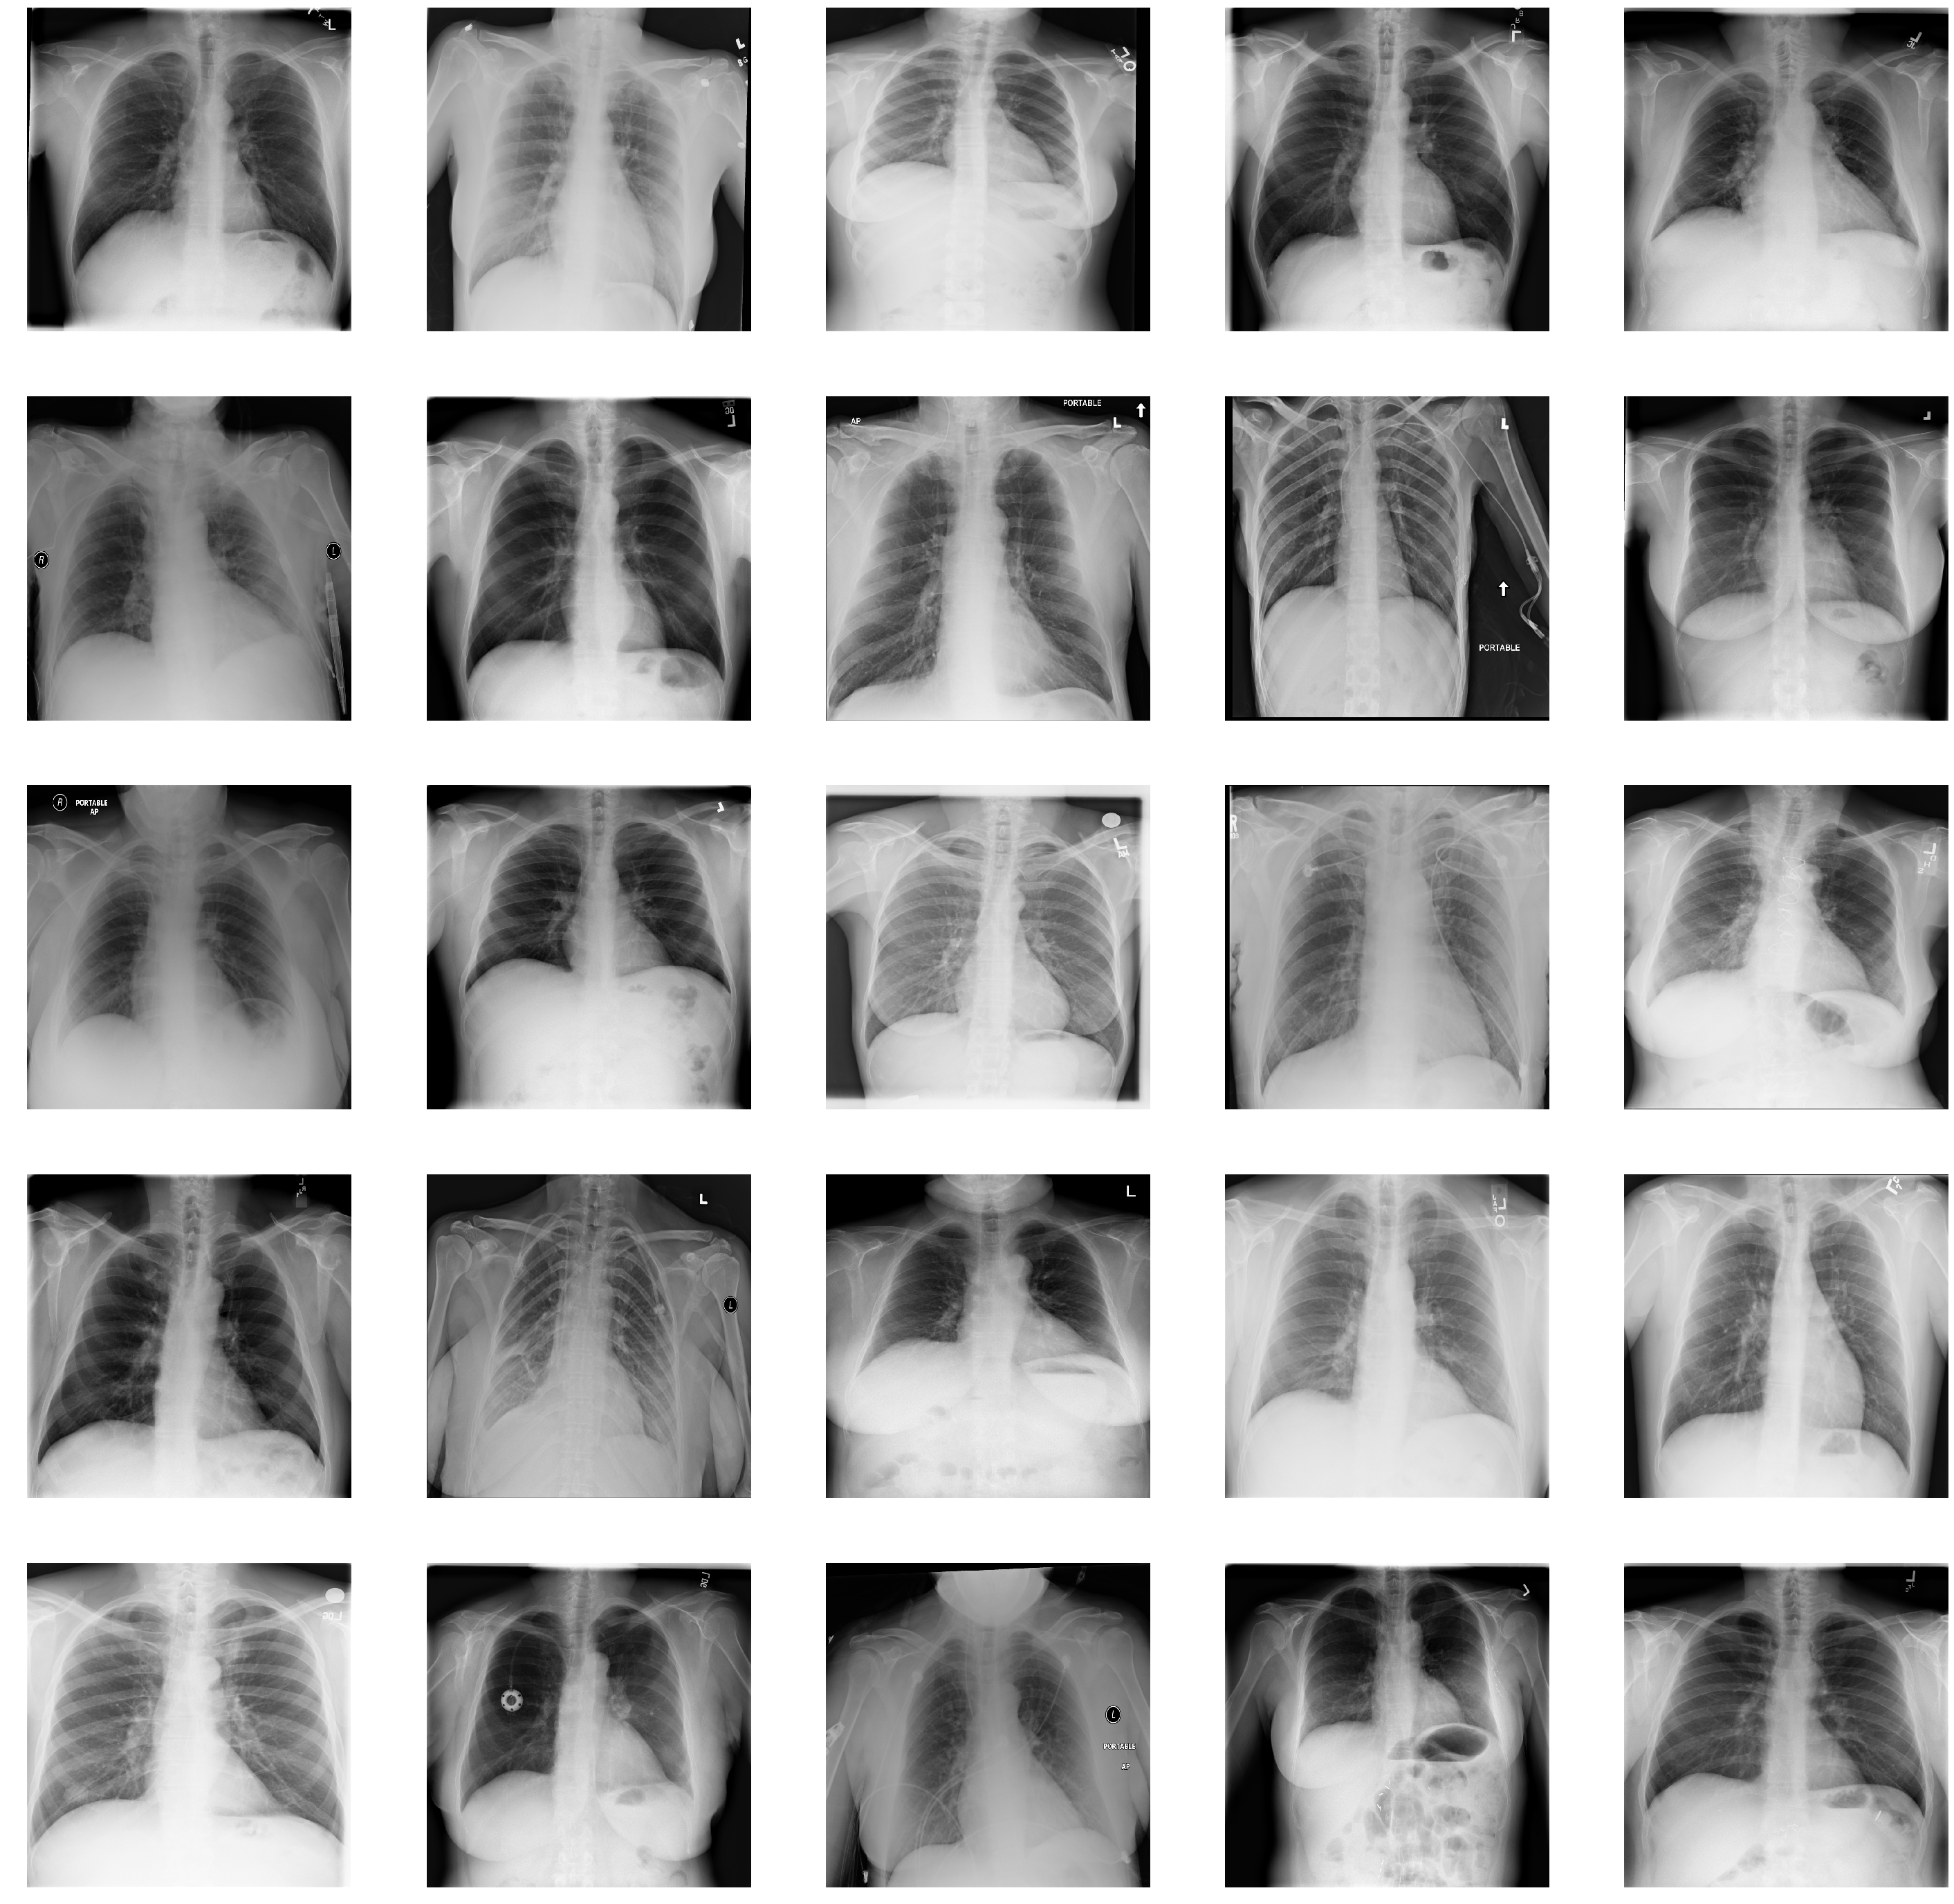

In [11]:
show_images(L(np.random.choice(train_val_files, 25).tolist()).map(PILImage.create),nrows=5,figsize=(50,50))

### Pretraining (SwAV)

In [12]:
from self_supervised.augmentations import *
from self_supervised.layers import *
from self_supervised.swav import *

In [13]:
from kornia.augmentation import RandomEqualize
from torchvision import transforms as tvtfm
from kornia import augmentation as korniatfm

In [14]:
from fastai.callback.wandb import WandbCallback
import wandb

In [15]:
def get_cxr_batch_augs(size,
                        rotate=True,
                        jitter=False,
                        bw=False,
                        blur=True,
                        equalize=True,
                        resize_scale=(0.3, 1.0),
                        resize_ratio=(3/4, 4/3),
                        rotate_deg=30,
                        s=.6,  
                        blur_s=(4,32),
                        same_on_batch=False,
                        flip_p=0.5, rotate_p=0.5, jitter_p=0.3, bw_p=0.3, blur_p=0.5, eqlz_p=0.5,
                        stats=imagenet_stats,
                        cuda=default_device().type == 'cuda',
                        xtra_tfms=[]):
    "Input batch augmentations implemented in tv+kornia+fastai"
    tfms = []
    tfms += [tvtfm.RandomResizedCrop((size, size), scale=resize_scale, ratio=resize_ratio)]
    tfms += [korniatfm.RandomHorizontalFlip(p=flip_p)]

    if rotate: tfms += [Rotate(max_deg=rotate_deg, p=rotate_p, batch=same_on_batch)]

    if jitter:   tfms += [korniatfm.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s, p=jitter_p, same_on_batch=same_on_batch)]
    if bw:       tfms += [korniatfm.RandomGrayscale(p=bw_p, same_on_batch=same_on_batch)]   
    if blur:     tfms += [RandomGaussianBlur(p=blur_p, s=blur_s, same_on_batch=same_on_batch)]
    if equalize: tfms += [RandomEqualize(p=eqlz_p, same_on_batch=same_on_batch)]
        
    if stats is not None: tfms += [Normalize.from_stats(*stats, cuda=cuda)]

    tfms += xtra_tfms
    pipe = Pipeline(tfms, split_idx = 0)
    return pipe

In [19]:
# Resize from 1024x1024 to 512x512
resize = 448
size = int(resize/1.6)
bs = 24
tfms = [[PILImage.create,  Resize((resize,resize)), ToTensor()]]
dsets = Datasets(train_val_files, tfms=tfms, n_inp=1, splits=RandomSplitter(valid_pct=0.1)(train_val_files))
batch_tfms = [IntToFloatTensor]
dls = dsets.dataloaders(bs=bs, num_workers=4, after_batch=batch_tfms)

In [20]:
arch = "resnet101d_320"
encoder = create_encoder(arch, pretrained=True, n_in=3)

In [21]:
xtra_config = {"Arch":arch, "Resize":resize, "Size":size, "Algorithm":"SWAV"}
wandb.init(project="self-supervised-nih-cxr", config=xtra_config);

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: keremturgutlu (use `wandb login --relogin` to force relogin)


In [22]:
# Use 320 large and 240 small crops
model = create_swav_model(encoder, n_in=3)
learn = Learner(dls, model, SWAVLoss(),
                cbs=[SWAV(aug_func=get_cxr_batch_augs,
                          crop_sizes=[size,int(3/4*size)],
                          num_crops=[2,4],
                          min_scales=[0.5,0.3],
                          max_scales=[1.0,0.5],                
                          rotate=True,
                          jitter=False,
                          bw=False,
                          blur=True,
                          equalize=True,
                          rotate_deg=30,
                          s=.6,  
                          blur_s=(4,16),
                          same_on_batch=False,
                          flip_p=0.5, rotate_p=0.5, eqlz_p=0.5, blur_p=0.3,
                          stats=imagenet_stats),
                     TerminateOnNaNCallback(),
                     WandbCallback(log_preds=False,log_model=False),
                     GradientAccumulation(n_acc=48)
                     ])

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomEqualize -> RandomGaussianBlur -- {'p': 0.3, 's': (4, 16), 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomEqualize -> RandomGaussianBlur -- {'p': 0.3, 's': (4, 16), 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}
Pipeline

In [23]:
resize, size

(448, 280)

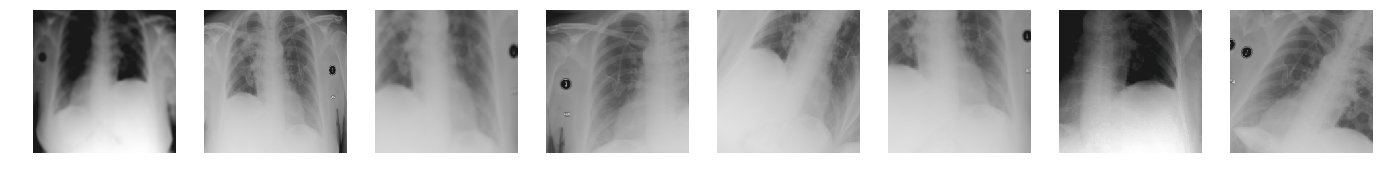

In [22]:
# b = dls.one_batch()
# learn._split(b)
# learn('before_batch')
# learn.swav.show_one()

In [24]:
lr=1e-2
wd=1e-2
epochs=30

In [ ]:
learn.to_fp16()
learn.unfreeze()
learn.fit_flat_cos(epochs, lr, wd=wd, pct_start=0.5)

In [ ]:
wandb.finish()

In [ ]:
learn.save(f"swav_nih_cxr_resize{resize}_size{size}_epc{epochs}")

### Check Learned Representation Quality